This notebook will search the metadata from Argo and provide info on the number of profiles near to the stations. the goal is to constrcut a seasonal cycle for evaluation of hackathon methods. 

In [17]:
from argopy import DataFetcher
import pandas as pd
import numpy as np
from geopy.distance import geodesic
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import calendar

import warnings
warnings.filterwarnings('ignore')

# Step 1: Load Line P stations
linep_stations = pd.read_csv('/gpfs/fs7/dfo/hpcmc/pfm/amh001/TOOLS/python/hackathon/LineP.csv')

print("Line P Stations loaded:")
print(linep_stations.head())
print(f"Total stations: {len(linep_stations)}\n")


Line P Stations loaded:
  station_name  latitude  longitude
0           P1   48.5750  -125.5000
1           P2   48.6000  -126.0000
2           P3   48.6250  -126.3333
3           P4   48.6500  -126.6667
4           P5   48.6917  -127.1667
Total stations: 27



In [11]:
# Step 1: Load Line P stations and examine structure
linep_stations = pd.read_csv('/gpfs/fs7/dfo/hpcmc/pfm/amh001/TOOLS/python/hackathon/LineP.csv')

print("Line P Stations loaded:")
print("Column names:", linep_stations.columns.tolist())
print("\nFirst few rows:")
print(linep_stations.head())
print(f"Total stations: {len(linep_stations)}")
print(f"Data types:\n{linep_stations.dtypes}\n")


Line P Stations loaded:
Column names: ['station_name', 'latitude', 'longitude']

First few rows:
  station_name  latitude  longitude
0           P1   48.5750  -125.5000
1           P2   48.6000  -126.0000
2           P3   48.6250  -126.3333
3           P4   48.6500  -126.6667
4           P5   48.6917  -127.1667
Total stations: 27
Data types:
station_name     object
latitude        float64
longitude       float64
dtype: object



In [13]:
# Step 2: Try to identify lat/lon columns automatically
def find_lat_lon_columns(df):
    """Automatically detect latitude and longitude columns"""
    lat_col = None
    lon_col = None
    station_col = None
    
    # Common variations for latitude columns
    lat_variations = ['latitude', 'lat', 'Latitude', 'LAT', 'LATITUDE', 'Lat']
    lon_variations = ['longitude', 'lon', 'long', 'Longitude', 'LON', 'LONGITUDE', 'Lon', 'Long']
    station_variations = ['station', 'Station', 'STATION', 'station_name', 'Station_Name', 'name', 'Name']
    
    for col in df.columns:
        if col in lat_variations:
            lat_col = col
        elif col in lon_variations:
            lon_col = col
        elif col in station_variations:
            station_col = col
    
    return lat_col, lon_col, station_col

lat_col, lon_col, station_col = find_lat_lon_columns(linep_stations)

print(f"Detected columns:")
print(f"- Latitude: {lat_col}")
print(f"- Longitude: {lon_col}")
print(f"- Station: {station_col}")

# If automatic detection fails, let user specify
if lat_col is None or lon_col is None:
    print("\nCould not automatically detect lat/lon columns.")
    print("Available columns:", linep_stations.columns.tolist())
    print("Please check your CSV file column names.")
    
    # You can manually specify the correct column names here:
    # lat_col = 'your_latitude_column_name'
    # lon_col = 'your_longitude_column_name'
    # station_col = 'your_station_column_name'
    
    # For now, let's try some common alternatives:
    possible_lat = [col for col in linep_stations.columns if 'lat' in col.lower()]
    possible_lon = [col for col in linep_stations.columns if 'lon' in col.lower() or 'lng' in col.lower()]
    
    if possible_lat:
        lat_col = possible_lat[0]
        print(f"Using '{lat_col}' as latitude column")
    if possible_lon:
        lon_col = possible_lon[0]
        print(f"Using '{lon_col}' as longitude column")

# Proceed only if we have lat/lon columns
if lat_col and lon_col:
    # Step 3: Define search parameters
    search_radius_km = 10  # 10km radius
    time_range = ['2014-01-01', '2021-01-01']  # Adjust as needed

    # Step 4: Get bounding box for Line P region
    lat_min = linep_stations[lat_col].min() - 0.5
    lat_max = linep_stations[lat_col].max() + 0.5
    lon_min = linep_stations[lon_col].min() - 0.5
    lon_max = linep_stations[lon_col].max() + 0.5

    print(f"\nSearch region: Lat [{lat_min:.2f}, {lat_max:.2f}], Lon [{lon_min:.2f}, {lon_max:.2f}]")

    # Step 5: Fetch Argo metadata in the region
    try:
        # Initialize fetcher for the region
        fetcher = DataFetcher()
        
        # Get index/metadata for profiles in the region
        print("Fetching Argo metadata...")
        argo_index = fetcher.region([lon_min, lon_max, lat_min, lat_max, 0, 1000, time_range[0], time_range[1]]).to_index()
        
        print(f"Found {len(argo_index)} Argo profiles in the broader region")
        print("Argo index columns:", argo_index.columns.tolist())
        print("\nSample Argo profile:")
        print(argo_index.head(1))

        # Step 6: Find profiles within 10km of any Line P station
        nearby_profiles = []
        
        print(f"\nSearching for profiles within {search_radius_km}km of Line P stations...")
        
        for idx, argo_profile in argo_index.iterrows():
            try:
                # Try different possible column names for Argo lat/lon
                if 'latitude' in argo_profile:
                    argo_lat = argo_profile['latitude']
                elif 'lat' in argo_profile:
                    argo_lat = argo_profile['lat']
                else:
                    print("Available Argo columns:", argo_profile.index.tolist())
                    break
                
                if 'longitude' in argo_profile:
                    argo_lon = argo_profile['longitude']
                elif 'lon' in argo_profile:
                    argo_lon = argo_profile['lon']
                else:
                    print("Available Argo columns:", argo_profile.index.tolist())
                    break
                
                argo_date = argo_profile.get('date', argo_profile.get('time', 'N/A'))
                
                # Check distance to each Line P station
                min_distance = float('inf')
                closest_station = None
                
                for _, station in linep_stations.iterrows():
                    station_lat = station[lat_col]
                    station_lon = station[lon_col]
                    
                    # Calculate distance using geodesic
                    distance = geodesic((argo_lat, argo_lon), (station_lat, station_lon)).kilometers
                    
                    if distance < min_distance:
                        min_distance = distance
                        if station_col:
                            closest_station = station[station_col]
                        else:
                            closest_station = f"Station_{linep_stations.index[linep_stations.index == station.name][0]}"
                
                # If within 10km of any station, add to list
                if min_distance <= search_radius_km:
                    nearby_profiles.append({
                        'profile_id': idx,
                        'float_id': argo_profile.get('platform_number', argo_profile.get('wmo', 'N/A')),
                        'latitude': argo_lat,
                        'longitude': argo_lon,
                        'date': argo_date,
                        'closest_station': closest_station,
                        'distance_km': round(min_distance, 2)
                    })
                
                # Progress indicator
                if len(nearby_profiles) % 10 == 0 and len(nearby_profiles) > 0:
                    print(f"Found {len(nearby_profiles)} nearby profiles so far...")
            
            except Exception as e:
                print(f"Error processing profile {idx}: {e}")
                continue

        # Step 7: Create results DataFrame
        results_df = pd.DataFrame(nearby_profiles)
        
        if len(results_df) > 0:
            print(f"\nFound {len(results_df)} Argo profiles within {search_radius_km}km of Line P stations:")
            print(results_df.head(10))
            
            # Summary statistics
            print(f"\nSummary:")
            print(f"- Total nearby profiles: {len(results_df)}")
            print(f"- Date range: {results_df['date'].min()} to {results_df['date'].max()}")
            print(f"- Average distance: {results_df['distance_km'].mean():.2f} km")
            print(f"- Closest profile: {results_df['distance_km'].min():.2f} km")
            
            # Profiles by station
            print(f"\nProfiles by closest Line P station:")
            station_counts = results_df['closest_station'].value_counts()
            print(station_counts.head(10))
            
            # Save results
            results_df.to_csv('argo_profiles_near_lineP.csv', index=False)
            print(f"\nResults saved to 'argo_profiles_near_lineP.csv'")
            
        else:
            print(f"\nNo Argo profiles found within {search_radius_km}km of Line P stations in the specified time period.")
            print("Try expanding the time range or search radius.")

    except Exception as e:
        print(f"Error during processing: {e}")
        import traceback
        traceback.print_exc()

else:
    print("Cannot proceed without latitude and longitude columns identified.")
    print("Please check your CSV file and manually specify the column names in the code.")

Detected columns:
- Latitude: latitude
- Longitude: longitude
- Station: station_name

Search region: Lat [48.08, 50.50], Lon [-145.50, -125.00]
Fetching Argo metadata...
Found 4238 Argo profiles in the broader region
Argo index columns: ['date', 'latitude', 'longitude', 'wmo', 'cyc']

Sample Argo profile:
                 date   latitude   longitude      wmo  cyc
0 2019-08-21 05:47:00  49.635605 -139.651901  4902474    1

Searching for profiles within 10km of Line P stations...
Found 10 nearby profiles so far...
Found 10 nearby profiles so far...
Found 10 nearby profiles so far...
Found 10 nearby profiles so far...
Found 10 nearby profiles so far...
Found 10 nearby profiles so far...
Found 10 nearby profiles so far...
Found 10 nearby profiles so far...
Found 10 nearby profiles so far...
Found 10 nearby profiles so far...
Found 10 nearby profiles so far...
Found 10 nearby profiles so far...
Found 10 nearby profiles so far...
Found 10 nearby profiles so far...
Found 10 nearby profiles s

Date range in data: 2014-02-14 08:26:00 to 2020-12-13 21:17:00
Years covered: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020)]
Total profiles: 171



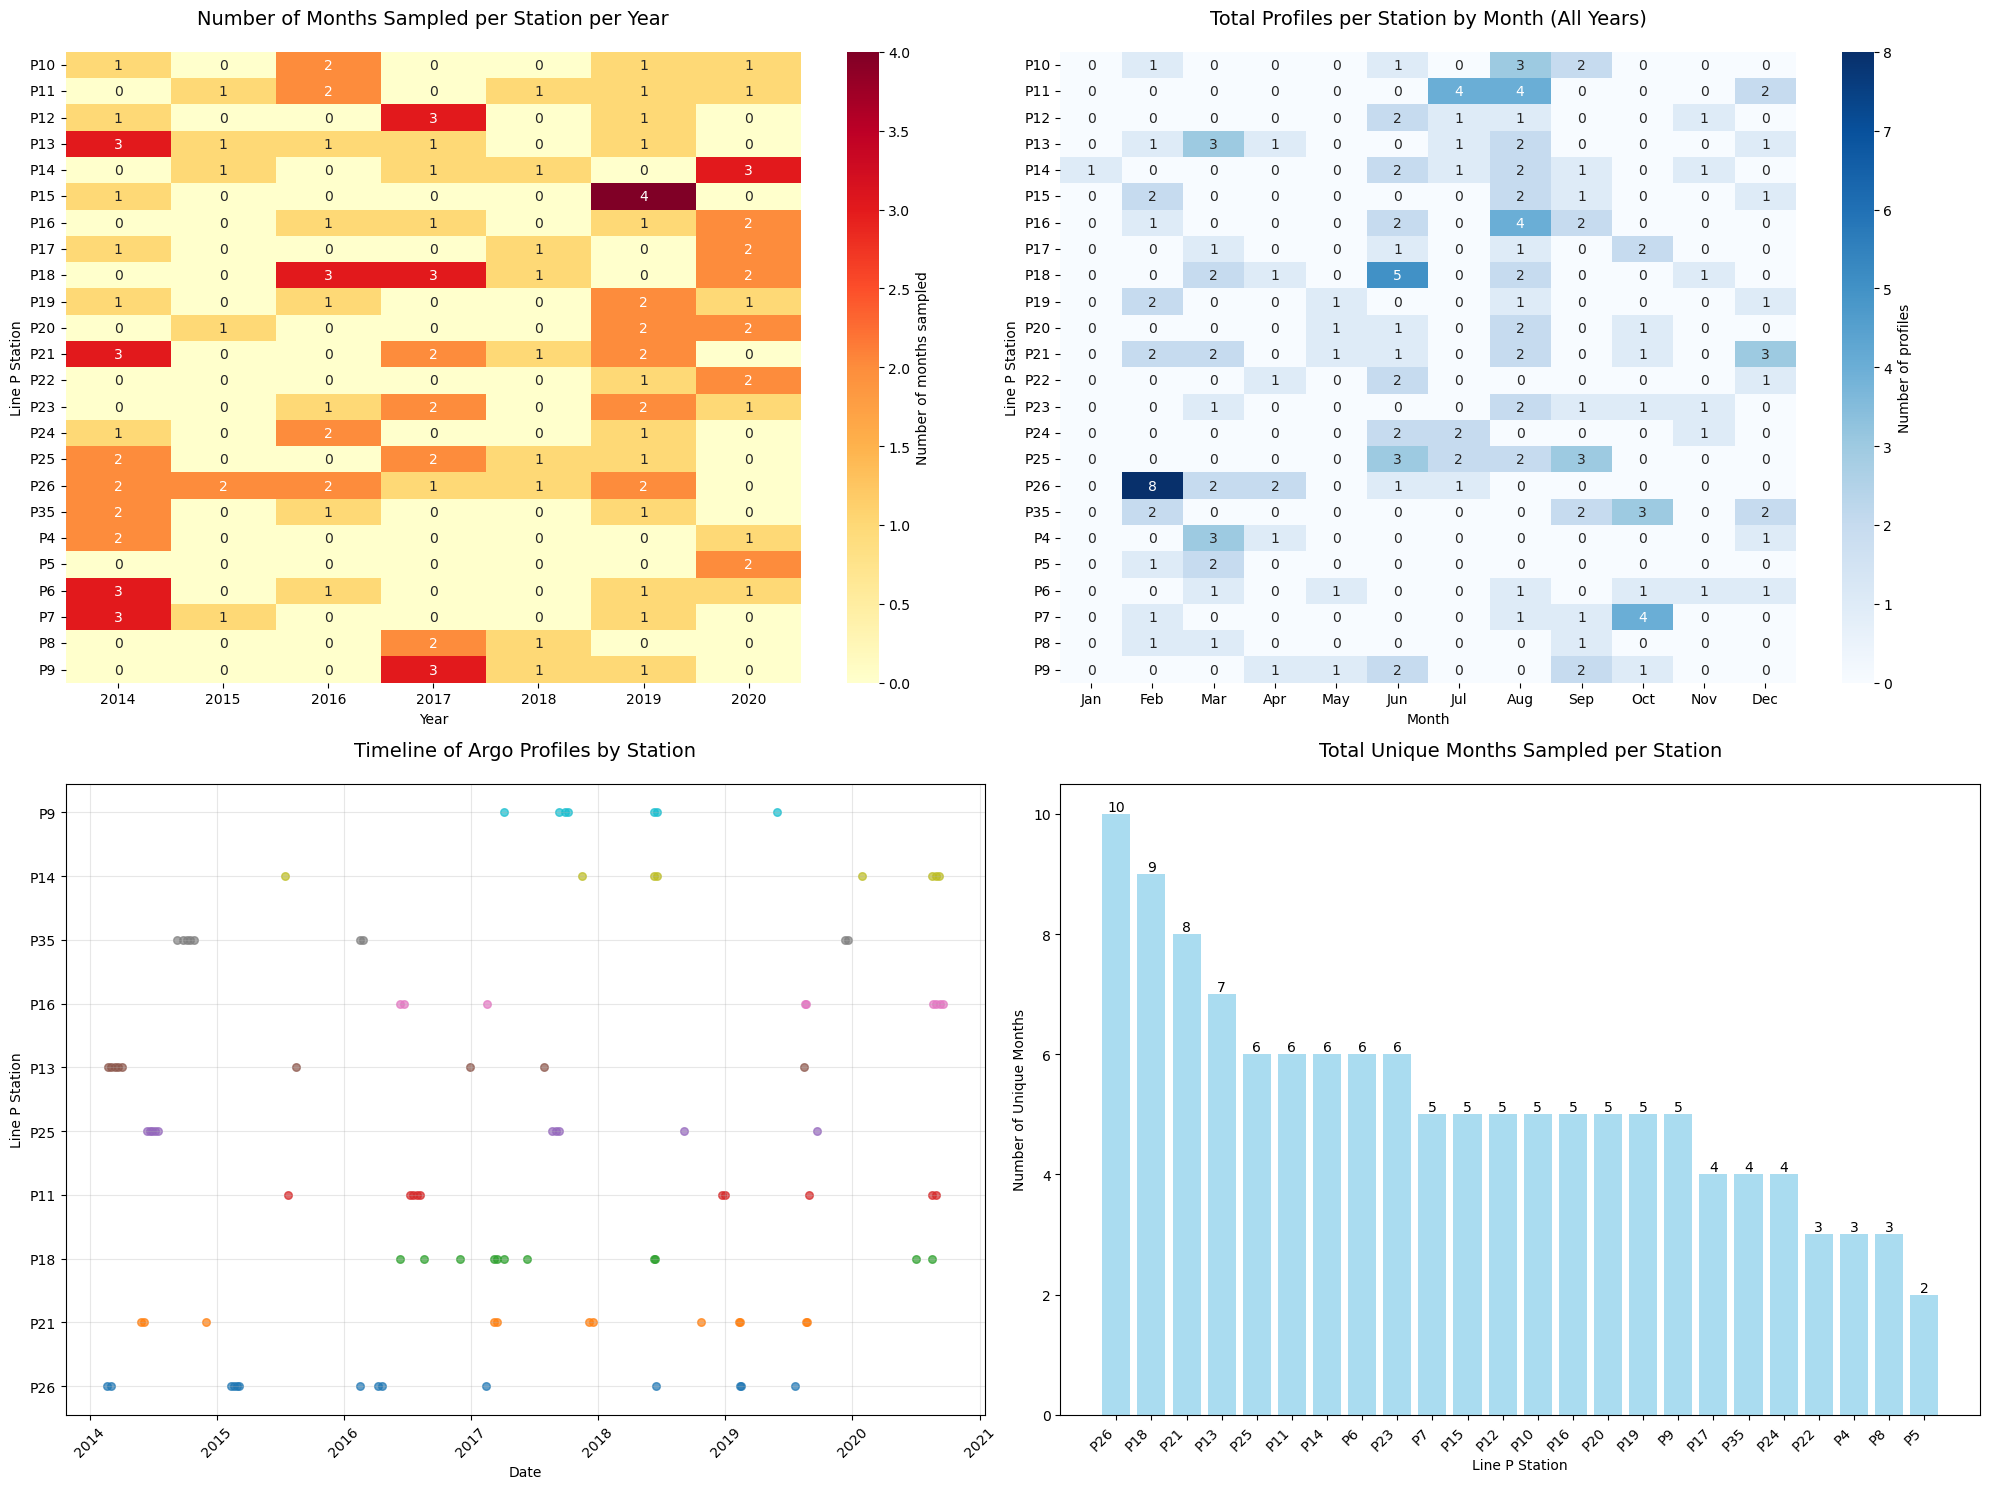

=== TEMPORAL COVERAGE SUMMARY ===

Overall Coverage:
- Stations with nearby Argo data: 24
- Total unique months covered: 58
- Years covered: 7
- Average profiles per station: 7.1

Station-level coverage:
                 Total_Profiles       First_Profile        Last_Profile  \
closest_station                                                           
P26                          14 2014-02-20 16:02:00 2019-07-21 05:48:00   
P21                          12 2014-05-29 10:12:00 2019-08-23 05:40:00   
P18                          11 2016-06-11 17:50:00 2020-08-17 05:37:00   
P11                          10 2015-07-23 10:57:00 2020-08-27 05:57:00   
P25                          10 2014-06-14 18:41:27 2019-09-20 15:26:12   
P13                           9 2014-02-22 22:29:00 2019-08-14 03:46:00   
P16                           9 2016-06-11 03:34:00 2020-09-18 09:00:00   
P35                           9 2014-09-07 10:30:00 2019-12-19 21:56:27   
P14                           8 2015-07-16 09:

In [18]:

# Assuming you have results_df from the previous search
if 'results_df' in locals() and len(results_df) > 0:
    
    # Convert date column to datetime if it's not already
    if results_df['date'].dtype == 'object':
        results_df['date'] = pd.to_datetime(results_df['date'])
    
    # Extract year and month
    results_df['year'] = results_df['date'].dt.year
    results_df['month'] = results_df['date'].dt.month
    results_df['year_month'] = results_df['date'].dt.to_period('M')
    
    print(f"Date range in data: {results_df['date'].min()} to {results_df['date'].max()}")
    print(f"Years covered: {sorted(results_df['year'].unique())}")
    print(f"Total profiles: {len(results_df)}\n")
    
    # Create figure with subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 15))
    
    # 1. Heatmap: Stations vs Years (showing number of months sampled per year)
    # Count unique months per station per year
    monthly_coverage = results_df.groupby(['closest_station', 'year'])['month'].nunique().reset_index()
    monthly_coverage_pivot = monthly_coverage.pivot(index='closest_station', 
                                                   columns='year', 
                                                   values='month').fillna(0)
    
    sns.heatmap(monthly_coverage_pivot, 
                annot=True, 
                fmt='g', 
                cmap='YlOrRd', 
                cbar_kws={'label': 'Number of months sampled'},
                ax=ax1)
    ax1.set_title('Number of Months Sampled per Station per Year', fontsize=14, pad=20)
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Line P Station')
    
    # 2. Heatmap: Stations vs Months (across all years)
    # Count profiles per station per month (across all years)
    station_month = results_df.groupby(['closest_station', 'month']).size().reset_index(name='count')
    station_month_pivot = station_month.pivot(index='closest_station', 
                                             columns='month', 
                                             values='count').fillna(0)
    
    # Use month names for better readability
    month_names = [calendar.month_abbr[i] for i in range(1, 13)]
    station_month_pivot.columns = [month_names[i-1] if i <= 12 else str(i) for i in station_month_pivot.columns]
    
    sns.heatmap(station_month_pivot, 
                annot=True, 
                fmt='g', 
                cmap='Blues', 
                cbar_kws={'label': 'Number of profiles'},
                ax=ax2)
    ax2.set_title('Total Profiles per Station by Month (All Years)', fontsize=14, pad=20)
    ax2.set_xlabel('Month')
    ax2.set_ylabel('Line P Station')
    
    # 3. Timeline plot: Profiles over time by station
    # Create a timeline showing profile dates
    stations_to_plot = results_df['closest_station'].value_counts().head(10).index  # Top 10 stations
    colors = plt.cm.tab10(np.linspace(0, 1, len(stations_to_plot)))
    
    for i, station in enumerate(stations_to_plot):
        station_data = results_df[results_df['closest_station'] == station]
        ax3.scatter(station_data['date'], 
                   [station] * len(station_data),
                   alpha=0.7, 
                   s=30, 
                   color=colors[i],
                   label=station)
    
    ax3.set_title('Timeline of Argo Profiles by Station', fontsize=14, pad=20)
    ax3.set_xlabel('Date')
    ax3.set_ylabel('Line P Station')
    ax3.tick_params(axis='x', rotation=45)
    ax3.grid(True, alpha=0.3)
    
    # 4. Bar plot: Total months sampled per station
    months_per_station = results_df.groupby('closest_station')['year_month'].nunique().sort_values(ascending=False)
    
    bars = ax4.bar(range(len(months_per_station)), 
                   months_per_station.values,
                   color='skyblue',
                   alpha=0.7)
    ax4.set_title('Total Unique Months Sampled per Station', fontsize=14, pad=20)
    ax4.set_xlabel('Line P Station')
    ax4.set_ylabel('Number of Unique Months')
    ax4.set_xticks(range(len(months_per_station)))
    ax4.set_xticklabels(months_per_station.index, rotation=45, ha='right')
    
    # Add value labels on bars
    for i, bar in enumerate(bars):
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom')
    
    plt.tight_layout()
    plt.savefig('argo_lineP_temporal_coverage.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Additional detailed analysis
    print("=== TEMPORAL COVERAGE SUMMARY ===\n")
    
    # Summary statistics
    total_stations = results_df['closest_station'].nunique()
    total_months = results_df['year_month'].nunique()
    total_years = results_df['year'].nunique()
    
    print(f"Overall Coverage:")
    print(f"- Stations with nearby Argo data: {total_stations}")
    print(f"- Total unique months covered: {total_months}")
    print(f"- Years covered: {total_years}")
    print(f"- Average profiles per station: {len(results_df)/total_stations:.1f}")
    
    # Station-level summary
    print(f"\nStation-level coverage:")
    station_summary = results_df.groupby('closest_station').agg({
        'date': ['count', 'min', 'max'],
        'year_month': 'nunique',
        'year': 'nunique'
    }).round(2)
    
    station_summary.columns = ['Total_Profiles', 'First_Profile', 'Last_Profile', 'Unique_Months', 'Years_Covered']
    station_summary = station_summary.sort_values('Total_Profiles', ascending=False)
    print(station_summary)
    
    # Year-by-year coverage
    print(f"\nYear-by-year coverage:")
    yearly_summary = results_df.groupby('year').agg({
        'closest_station': 'nunique',
        'date': 'count',
        'month': 'nunique'
    })
    yearly_summary.columns = ['Stations_Sampled', 'Total_Profiles', 'Months_Covered']
    print(yearly_summary)
    
    # Monthly patterns across all years
    print(f"\nSeasonal patterns (all years combined):")
    monthly_patterns = results_df.groupby('month').agg({
        'closest_station': 'nunique',
        'date': 'count'
    })
    monthly_patterns.columns = ['Stations_Sampled', 'Total_Profiles']
    monthly_patterns.index = [calendar.month_name[i] for i in monthly_patterns.index]
    print(monthly_patterns)
    
    # Save detailed results
    station_summary.to_csv('lineP_argo_station_coverage.csv')
    yearly_summary.to_csv('lineP_argo_yearly_coverage.csv')
    monthly_patterns.to_csv('lineP_argo_monthly_patterns.csv')
    
    print(f"\nDetailed coverage data saved to CSV files:")
    print("- lineP_argo_station_coverage.csv")
    print("- lineP_argo_yearly_coverage.csv") 
    print("- lineP_argo_monthly_patterns.csv")

else:
    print("No results_df found. Please run the Argo search code first to generate the data.")

# Optional: Create an interactive version using plotly (if available)
try:
    import plotly.express as px
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots
    
    if 'results_df' in locals() and len(results_df) > 0:
        # Interactive heatmap
        fig_interactive = px.density_heatmap(
            results_df, 
            x='year', 
            y='closest_station',
            title='Argo Profiles near Line P Stations by Year and Station',
            labels={'count': 'Number of Profiles'}
        )
        
        fig_interactive.update_layout(height=600, width=800)
        fig_interactive.write_html('lineP_argo_interactive_coverage.html')
        print("\nInteractive plot saved as 'lineP_argo_interactive_coverage.html'")
        
except ImportError:
    print("Plotly not available for interactive plots")

=== FINDING STATIONS WITH MULTI-MONTH COVERAGE IN SINGLE YEARS ===

Found 34 station-year combinations with multiple months of coverage:

   station  year  months_covered
22     P15  2019               4
10     P12  2017               3
12     P13  2014               3
20     P14  2020               3
30     P18  2016               3
31     P18  2017               3
41     P21  2014               3
70      P6  2014               3
74      P7  2014               3
79      P9  2017               3
1      P10  2016               2
5      P11  2016               2
26     P16  2020               2
29     P17  2020               2
33     P18  2020               2
36     P19  2019               2
39     P20  2019               2
40     P20  2020               2
42     P21  2017               2
44     P21  2019               2
46     P22  2020               2
48     P23  2017               2
49     P23  2019               2
52     P24  2016               2
54     P25  2014               2
55  

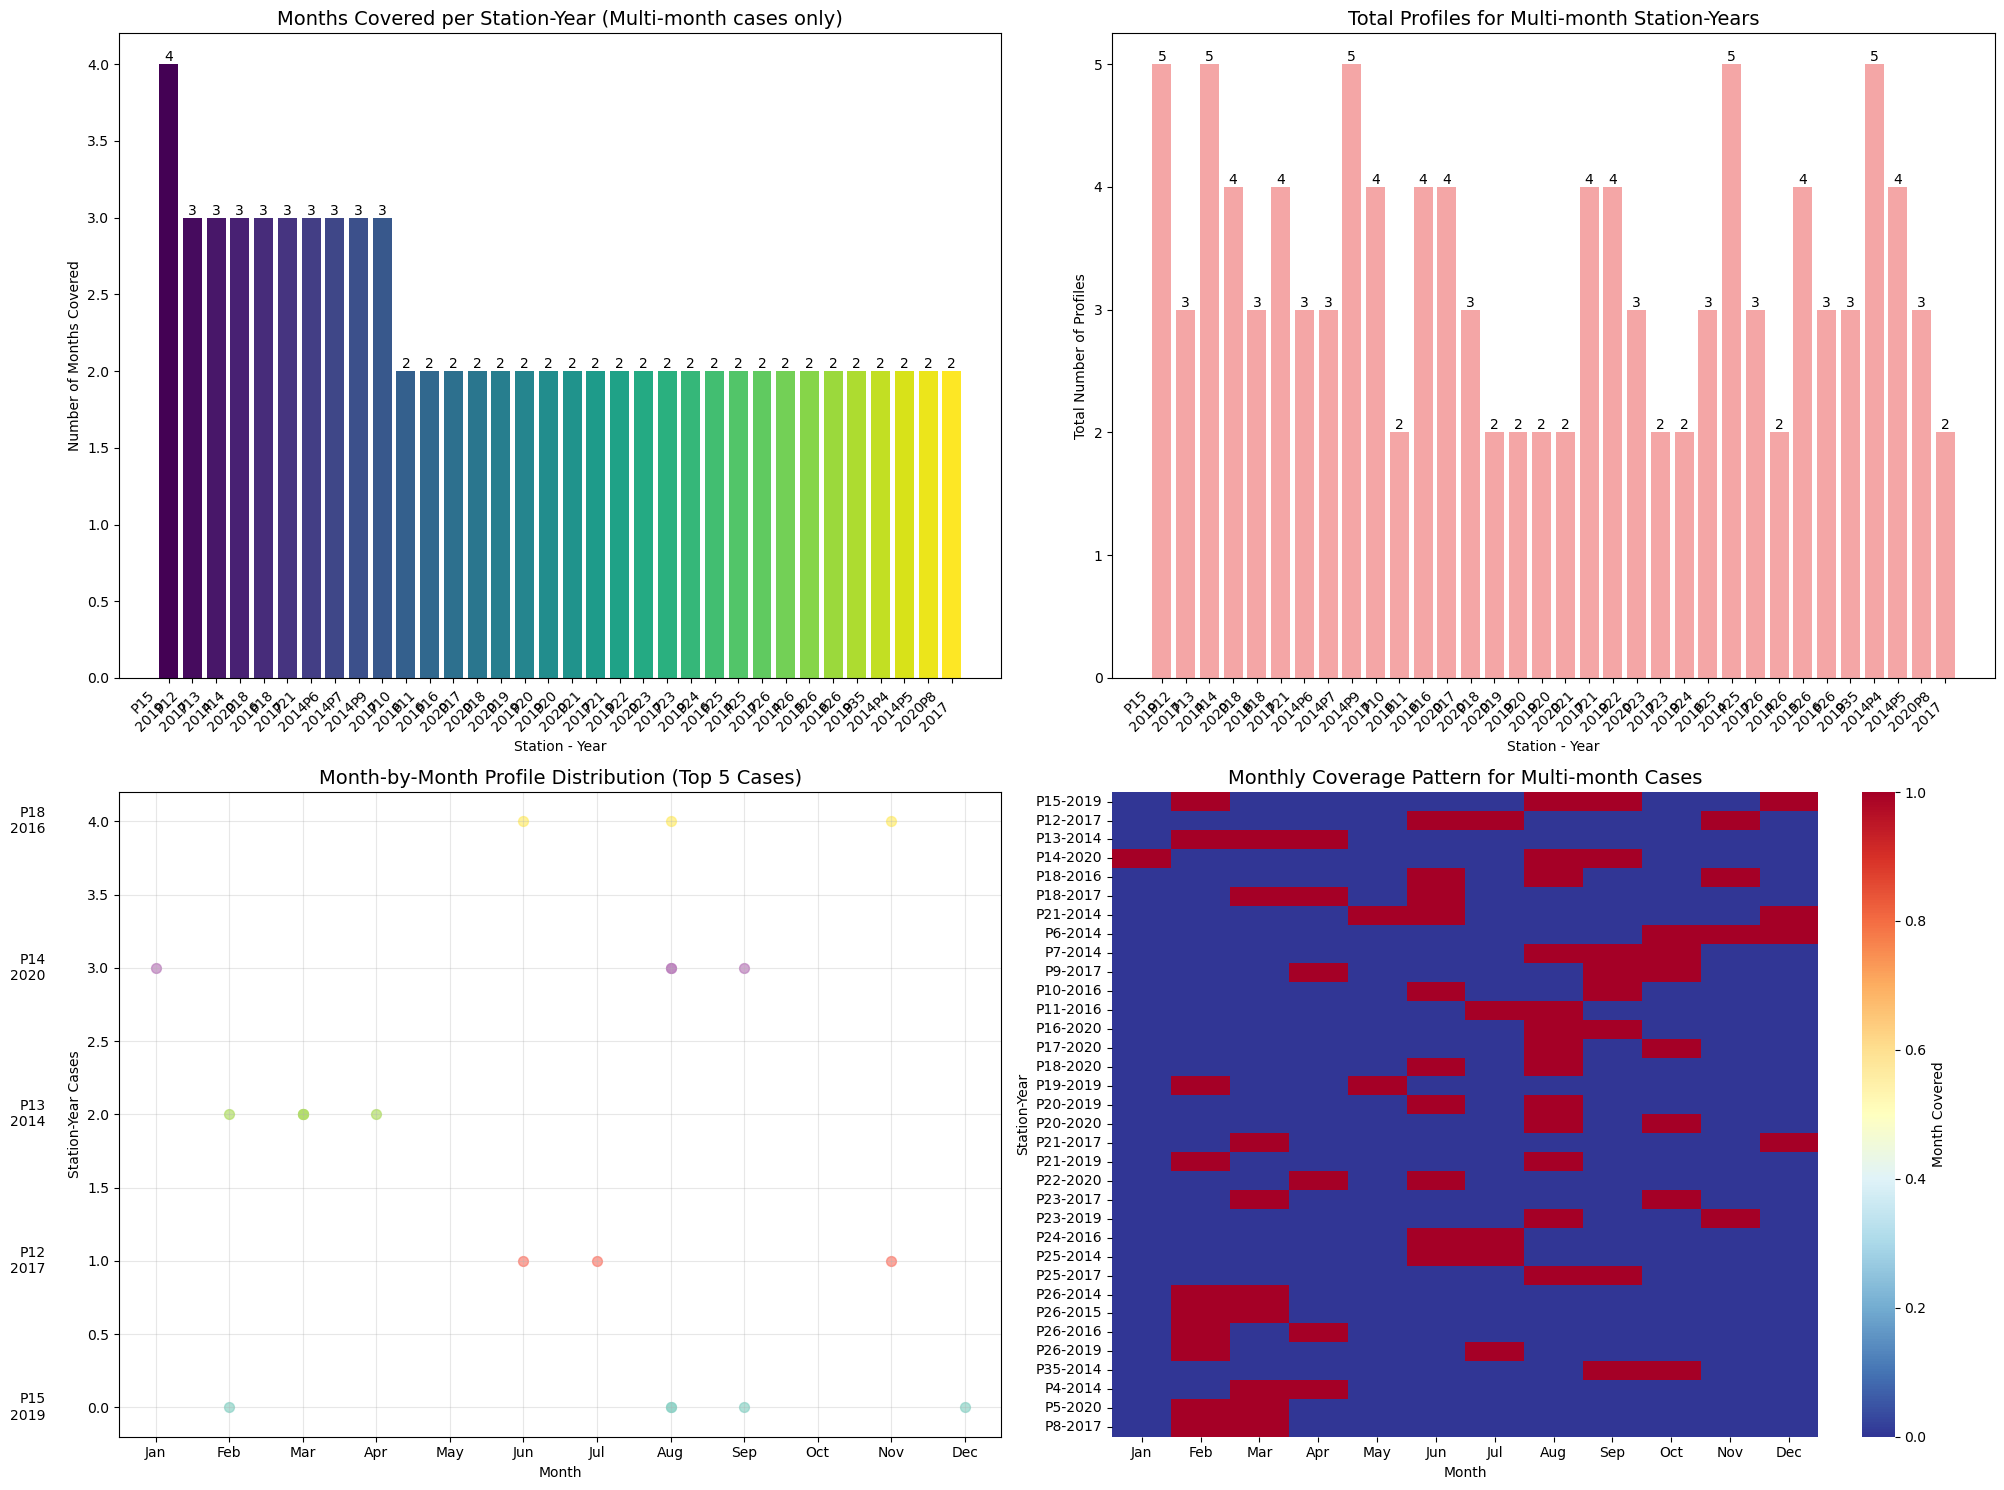


=== SUMMARY STATISTICS ===
Total station-year combinations with multi-month coverage: 34
Maximum months covered in a single year: 4
Average months covered (multi-month cases): 2.3

Best coverage cases (4 months):
  - P15 in 2019

Results saved to:
- lineP_multi_month_coverage.csv
- lineP_multi_month_details.csv


In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import calendar

# Assuming you have results_df from the previous search
if 'results_df' in locals() and len(results_df) > 0:
    
    # Ensure date is datetime
    if results_df['date'].dtype == 'object':
        results_df['date'] = pd.to_datetime(results_df['date'])
    
    # Extract year and month
    results_df['year'] = results_df['date'].dt.year
    results_df['month'] = results_df['date'].dt.month
    results_df['year_month'] = results_df['date'].dt.to_period('M')
    
    # Find stations with multiple months in a single year
    print("=== FINDING STATIONS WITH MULTI-MONTH COVERAGE IN SINGLE YEARS ===\n")
    
    # Count unique months per station per year
    station_year_months = results_df.groupby(['closest_station', 'year'])['month'].nunique().reset_index()
    station_year_months.columns = ['station', 'year', 'months_covered']
    
    # Filter for stations with 2+ months in a single year
    multi_month_coverage = station_year_months[station_year_months['months_covered'] >= 2].copy()
    multi_month_coverage = multi_month_coverage.sort_values(['months_covered', 'station', 'year'], ascending=[False, True, True])
    
    print(f"Found {len(multi_month_coverage)} station-year combinations with multiple months of coverage:\n")
    print(multi_month_coverage)
    
    if len(multi_month_coverage) > 0:
        # Get detailed breakdown for multi-month cases
        print("\n=== DETAILED BREAKDOWN ===")
        
        detailed_breakdown = []
        for _, row in multi_month_coverage.iterrows():
            station = row['station']
            year = row['year']
            months_count = row['months_covered']
            
            # Get specific months and profile counts for this station-year
            station_year_data = results_df[
                (results_df['closest_station'] == station) & 
                (results_df['year'] == year)
            ]
            
            # Get month details
            month_details = station_year_data.groupby('month').agg({
                'date': 'count',  # number of profiles
                'date': ['count', 'min', 'max']  # count, first date, last date
            }).round(2)
            
            month_summary = station_year_data.groupby('month').agg({
                'profile_id': 'count',
                'date': ['min', 'max']
            })
            month_summary.columns = ['profiles', 'first_date', 'last_date']
            
            months_list = sorted(station_year_data['month'].unique())
            months_names = [calendar.month_abbr[m] for m in months_list]
            
            print(f"\n{station} - {year} ({months_count} months):")
            print(f"  Months: {', '.join(months_names)}")
            print("  Details by month:")
            for month in months_list:
                month_data = station_year_data[station_year_data['month'] == month]
                print(f"    {calendar.month_name[month]}: {len(month_data)} profiles ({month_data['date'].min().strftime('%Y-%m-%d')} to {month_data['date'].max().strftime('%Y-%m-%d')})")
            
            # Store for plotting
            detailed_breakdown.append({
                'station': station,
                'year': year,
                'months_covered': months_count,
                'months_list': months_list,
                'total_profiles': len(station_year_data),
                'date_range': f"{station_year_data['date'].min().strftime('%Y-%m-%d')} to {station_year_data['date'].max().strftime('%Y-%m-%d')}"
            })
        
        # Create visualizations
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 15))
        
        # 1. Bar chart: Number of months covered per station-year combination
        x_labels = [f"{row['station']}\n{row['year']}" for row in detailed_breakdown]
        months_counts = [row['months_covered'] for row in detailed_breakdown]
        colors = plt.cm.viridis(np.linspace(0, 1, len(months_counts)))
        
        bars1 = ax1.bar(range(len(x_labels)), months_counts, color=colors)
        ax1.set_title('Months Covered per Station-Year (Multi-month cases only)', fontsize=14)
        ax1.set_xlabel('Station - Year')
        ax1.set_ylabel('Number of Months Covered')
        ax1.set_xticks(range(len(x_labels)))
        ax1.set_xticklabels(x_labels, rotation=45, ha='right')
        
        # Add value labels on bars
        for i, bar in enumerate(bars1):
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height,
                    f'{int(height)}',
                    ha='center', va='bottom')
        
        # 2. Total profiles for multi-month cases
        profile_counts = [row['total_profiles'] for row in detailed_breakdown]
        bars2 = ax2.bar(range(len(x_labels)), profile_counts, color='lightcoral', alpha=0.7)
        ax2.set_title('Total Profiles for Multi-month Station-Years', fontsize=14)
        ax2.set_xlabel('Station - Year')
        ax2.set_ylabel('Total Number of Profiles')
        ax2.set_xticks(range(len(x_labels)))
        ax2.set_xticklabels(x_labels, rotation=45, ha='right')
        
        for i, bar in enumerate(bars2):
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height,
                    f'{int(height)}',
                    ha='center', va='bottom')
        
        # 3. Detailed month-by-month view for top cases
        # Focus on the cases with most months covered
        top_cases = sorted(detailed_breakdown, key=lambda x: x['months_covered'], reverse=True)[:5]
        
        if top_cases:
            # Create a detailed timeline for top cases
            y_pos = 0
            colors_timeline = plt.cm.Set3(np.linspace(0, 1, len(top_cases)))
            
            for i, case in enumerate(top_cases):
                station = case['station']
                year = case['year']
                
                # Get data for this case
                case_data = results_df[
                    (results_df['closest_station'] == station) & 
                    (results_df['year'] == year)
                ]
                
                # Plot each profile as a point
                for _, profile in case_data.iterrows():
                    ax3.scatter(profile['month'], y_pos, 
                              color=colors_timeline[i], 
                              s=50, alpha=0.7)
                
                # Add station-year label
                ax3.text(-0.5, y_pos, f"{station}\n{year}", 
                        ha='right', va='center', fontsize=10)
                
                y_pos += 1
            
            ax3.set_title('Month-by-Month Profile Distribution (Top 5 Cases)', fontsize=14)
            ax3.set_xlabel('Month')
            ax3.set_ylabel('Station-Year Cases')
            ax3.set_xticks(range(1, 13))
            ax3.set_xticklabels([calendar.month_abbr[i] for i in range(1, 13)])
            ax3.grid(True, alpha=0.3)
            ax3.set_xlim(0.5, 12.5)
        
        # 4. Heatmap showing which months are covered for multi-month cases
        if len(detailed_breakdown) > 0:
            # Create matrix for heatmap
            heatmap_data = []
            case_labels = []
            
            for case in detailed_breakdown:
                row = [0] * 12  # 12 months
                for month in case['months_list']:
                    row[month-1] = 1  # Mark month as covered
                heatmap_data.append(row)
                case_labels.append(f"{case['station'][:8]}-{case['year']}")  # Truncate long station names
            
            heatmap_array = np.array(heatmap_data)
            month_labels = [calendar.month_abbr[i] for i in range(1, 13)]
            
            sns.heatmap(heatmap_array, 
                       xticklabels=month_labels,
                       yticklabels=case_labels,
                       cmap='RdYlBu_r',
                       cbar_kws={'label': 'Month Covered'},
                       ax=ax4)
            ax4.set_title('Monthly Coverage Pattern for Multi-month Cases', fontsize=14)
            ax4.set_xlabel('Month')
            ax4.set_ylabel('Station-Year')
        
        plt.tight_layout()
        plt.savefig('lineP_multi_month_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        # Summary statistics
        print(f"\n=== SUMMARY STATISTICS ===")
        print(f"Total station-year combinations with multi-month coverage: {len(multi_month_coverage)}")
        print(f"Maximum months covered in a single year: {multi_month_coverage['months_covered'].max()}")
        print(f"Average months covered (multi-month cases): {multi_month_coverage['months_covered'].mean():.1f}")
        
        # Best cases
        best_coverage = multi_month_coverage[multi_month_coverage['months_covered'] == multi_month_coverage['months_covered'].max()]
        print(f"\nBest coverage cases ({multi_month_coverage['months_covered'].max()} months):")
        for _, row in best_coverage.iterrows():
            print(f"  - {row['station']} in {row['year']}")
        
        # Save results
        multi_month_coverage.to_csv('lineP_multi_month_coverage.csv', index=False)
        
        # Save detailed breakdown
        detailed_df = pd.DataFrame(detailed_breakdown)
        detailed_df.to_csv('lineP_multi_month_details.csv', index=False)
        
        print(f"\nResults saved to:")
        print("- lineP_multi_month_coverage.csv")
        print("- lineP_multi_month_details.csv")
        
    else:
        print("No stations found with multiple months of coverage in a single year.")
        print("All Argo profiles appear to be from single-month sampling at each station.")
        
        # Show what we do have
        print(f"\nWhat we do have:")
        print("Single-month coverage by station-year:")
        single_month = station_year_months[station_year_months['months_covered'] == 1]
        print(f"  - {len(single_month)} station-year combinations with single-month coverage")
        print(f"  - {single_month['station'].nunique()} unique stations")
        print(f"  - Years: {sorted(single_month['year'].unique())}")

else:
    print("No results_df found. Please run the Argo search code first to generate the data.")